In [1]:
import torchaudio
import sys
sys.path.append("..")
from main.module_controlnet import window_rms, low_pass_filter

rms_window_size = 10000
low_pass_window_size = 2000

waveform, sample_rate = torchaudio.load("/homes/rfg543/Documents/Stable-Video2Audio/output/out/input_0_video_2015-02-22-14-20-13.wav", normalize=True)
waveform = waveform.unsqueeze(0)
rms_envelope = window_rms(waveform, window_size=rms_window_size)
filtered_envelope = low_pass_filter(rms_envelope, window_size=low_pass_window_size)
mu_law = torchaudio.transforms.MuLawEncoding(quantization_channels=64)
waveform_encoded = mu_law(filtered_envelope)

/homes/rfg543/.conda/envs/stableaudio/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(waveform.shape)
print(waveform_encoded.shape)
print(rms_envelope.shape)

torch.Size([1, 2, 441000])
torch.Size([1, 2, 441000])
torch.Size([1, 2, 441000])


In [3]:
import torch
#max and min of filtered envelope
print(torch.max(filtered_envelope))
print(torch.min(filtered_envelope))

#max and min of waveform encoded
print(torch.max(waveform_encoded))
print(torch.min(waveform_encoded))

tensor(0.2077)
tensor(0.0004)
tensor(52)
tensor(32)


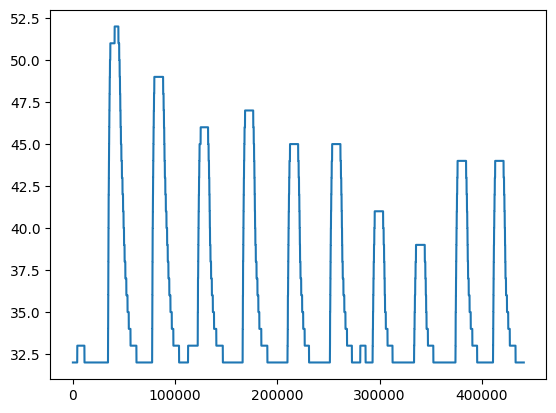

In [4]:
#plot of waveform encoded
import matplotlib.pyplot as plt
plt.plot(waveform_encoded[0][0])
plt.show()


In [5]:
bins = 64
min_val = torch.min(waveform_encoded).item()
max_val = torch.max(waveform_encoded).item()

discretized_envelope = ((waveform_encoded  - min_val) / (max_val - min_val) * (bins - 1)).long()

In [6]:
print(torch.max(discretized_envelope))
print(torch.min(discretized_envelope))

tensor(63)
tensor(0)


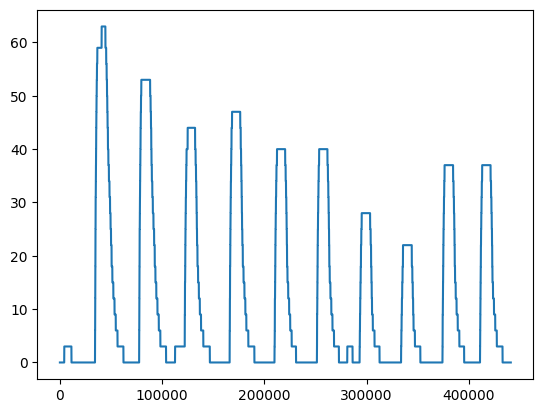

In [7]:
import matplotlib.pyplot as plt
plt.plot(discretized_envelope[0][0])
plt.show()

In [8]:
print(discretized_envelope.shape)

torch.Size([1, 2, 441000])


In [9]:
import torch.nn.functional as F
discretized_envelope = discretized_envelope.float()
resized = F.interpolate(discretized_envelope, size=300, mode='nearest')

In [10]:
print(resized.shape)

torch.Size([1, 2, 300])


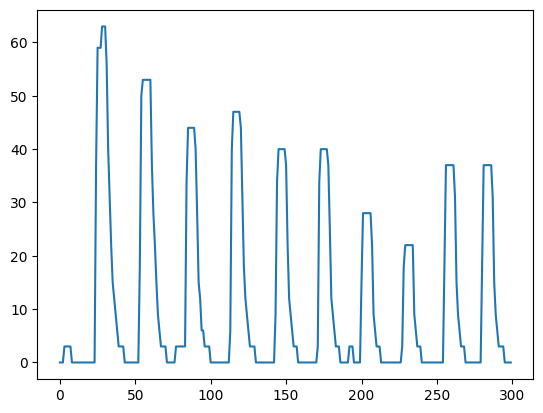

In [11]:
import matplotlib.pyplot as plt
plt.plot(resized[0][0])
plt.show()

In [5]:
import torch
import torch.nn.functional as F
import numpy as np

# def gaussian_label_smoothing(y_true, num_bins, sigma=1.0, window_size=2):
#     """
#     Applica il Gaussian Label Smoothing alle etichette discretizzate.
    
#     Args:
#         y_true: Tensor delle etichette vere (dimensione: batch_size).
#         num_bins: Numero totale dei bin (64 nel tuo caso).
#         sigma: Deviazione standard per la funzione gaussiana.
#         window_size: La finestra che determina quali classi vicine considerare.
    
#     Returns:
#         smoothed_labels: Tensor delle etichette smussate (dimensione: batch_size x num_bins).
#     """
#     batch_size = y_true.size(0)
#     smoothed_labels = torch.zeros((batch_size, num_bins), dtype=torch.float32)
    
#     for i in range(batch_size):
#         c_gt = y_true[i].item()  # Classe corretta (valore discreto tra 0 e 63)
#         for ci in range(max(0, c_gt - window_size), min(num_bins, c_gt + window_size + 1)):
#             smoothed_labels[i, ci] = np.exp(-((ci - c_gt) ** 2) / (2 * sigma ** 2))
        
#         # Normalizzazione
#         # smoothed_labels[i] /= smoothed_labels[i].sum()
    
#     return smoothed_labels

def gaussian_label_smoothing(y_true, num_bins, sigma=1.0, window_size=2):
    """
    Applies Gaussian Label Smoothing to discretized labels.
    
    Args:
        y_true: Tensor of true labels (size: batch_size x 30).
        num_bins: Total number of bins (64 in this case).
        sigma: Standard deviation for the Gaussian function.
        window_size: The window that determines which nearby classes to consider.
    
    Returns:
        smoothed_labels: Tensor of smoothed labels (size: batch_size x 30 x num_bins).
    """
    batch_size, seq_len = y_true.size()
    smoothed_labels = torch.zeros((batch_size, seq_len, num_bins), dtype=torch.float32)
    
    for i in range(batch_size):
        for j in range(seq_len):
            c_gt = y_true[i, j].item()  # Correct class (discrete value between 0 and 63)
            for ci in range(max(0, c_gt - window_size), min(num_bins, c_gt + window_size + 1)):
                smoothed_labels[i, j, ci] = np.exp(-((ci - c_gt) ** 2) / (2 * sigma ** 2))
            
            # Normalization
            # smoothed_labels[i, j] /= smoothed_labels[i, j].sum()
    
    return smoothed_labels

# Esempio d'uso:
num_bins = 64
# resized = resized.long()
# y_true = resized[0][0]  # Le etichette corrette per tre esempi nel batch
# generate random labels of shape (1, 30) made of integers
y_true = torch.randint(0, num_bins, (1, 30))
smoothed_labels = gaussian_label_smoothing(y_true, num_bins, sigma=1.0, window_size=2)

print("Etichette smussate:\n", smoothed_labels)


Etichette smussate:
 tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.6065, 1.0000, 0.6065,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])


In [6]:
print(smoothed_labels.shape)

torch.Size([1, 30, 64])


In [13]:
import torch
import torch.nn.functional as F
import torchaudio

In [14]:
def window_rms(x, window_size):
    padding_size = window_size - 1
    x2 = torch.nn.functional.pad(x ** 2, (padding_size, 0), mode='constant', value=0)
    window = torch.ones(x2.shape[1], 1, window_size, device=x2.device) / float(window_size)
    rms_envelope = torch.sqrt(torch.nn.functional.conv1d(x2, window, stride=1, groups=x2.shape[1]))
    return rms_envelope

def low_pass_filter(x, window_size):
    low_pass_kernel = torch.ones(x.shape[1], 1, window_size, device=x.device) / window_size
    filtered_signal = torch.nn.functional.conv1d(x, low_pass_kernel, stride=1, padding=window_size // 2, groups=x.shape[1])
    return filtered_signal[:, :, :x.shape[-1]]

def rms_mulaw_encoding(audio, seq_len):
    print(audio.shape)
    rms_envelope = window_rms(audio, window_size=rms_window_size)
    filtered_envelope = low_pass_filter(rms_envelope, window_size=low_pass_window_size)
    print(filtered_envelope.shape)
    resized_envelope = F.interpolate(filtered_envelope.float(), size=seq_len, mode='nearest')
    print(resized_envelope.shape)
    mu_law = torchaudio.transforms.MuLawEncoding(64)
    waveform_encoded = mu_law(resized_envelope)
    min_val = torch.min(waveform_encoded).item()
    max_val = torch.max(waveform_encoded).item()
    labels = ((waveform_encoded  - min_val) / (max_val - min_val) * (64 - 1)).long()
    return labels

In [3]:
rms_window_size = 10000
low_pass_window_size = 2000
#load 2s of audio with torchaudio and resample a 44100
audio, sample_rate = torchaudio.load("/import/c4dm-datasets-ext/DIFF-SFX/GREATEST-HITS-DATASET/mic-mp4-processed-4fps-16kHz/2015-02-16-16-49-06/audio/2015-02-16-16-49-06.resampled.wav", normalize=True)
audio = audio[:, :2 * sample_rate]
audio = audio.unsqueeze(0)
resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=44100)
audio = resample(audio)
print(audio.shape)

torch.Size([1, 1, 88200])


In [15]:
# random audio of shape 8, 1, 88200
audio_rand = torch.rand(8, 1, 88200)
labels = rms_mulaw_encoding(audio_rand, seq_len=30)
print(labels.shape)
#max and min of labels
print(torch.max(labels))
print(torch.min(labels))

torch.Size([8, 1, 88200])
torch.Size([8, 1, 88200])
torch.Size([8, 1, 30])
torch.Size([8, 1, 30])
tensor(63)
tensor(0)


In [12]:
import numpy as np

def gaussian_label_smoothing(y_true, num_bins, sigma=1.0, window_size=2):
    """
    Applies Gaussian Label Smoothing to discretized labels.
    
    Args:
        y_true: Tensor of true labels (size: batch_size x 30).
        num_bins: Total number of bins (64 in this case).
        sigma: Standard deviation for the Gaussian function.
        window_size: The window that determines which nearby classes to consider.
    
    Returns:
        smoothed_labels: Tensor of smoothed labels (size: batch_size x 30 x num_bins).
    """
    y_true = y_true.squeeze(1)
    batch_size, seq_len = y_true.size()
    smoothed_labels = torch.zeros((batch_size, seq_len, num_bins), dtype=torch.float32)
    
    for i in range(batch_size):
        for j in range(seq_len):
            c_gt = y_true[i, j].item()  # Correct class (discrete value between 0 and 63)
            for ci in range(max(0, c_gt - window_size), min(num_bins, c_gt + window_size + 1)):
                smoothed_labels[i, j, ci] = np.exp(-((ci - c_gt) ** 2) / (2 * sigma ** 2))
            
            # Normalization
            # smoothed_labels[i, j] /= smoothed_labels[i, j].sum()
    
    return smoothed_labels

labels = gaussian_label_smoothing(labels, num_bins=64, sigma=1.0, window_size=2)
print(labels.shape)

torch.Size([1, 30, 64])


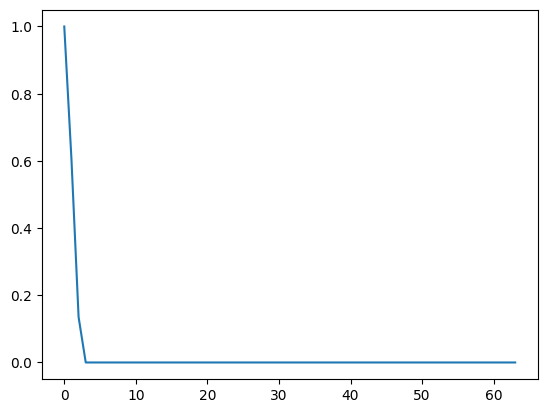

In [13]:
import matplotlib.pyplot as plt
plt.plot(labels[0][0])
plt.show()

In [10]:
import numpy as np

class CELoss(torch.nn.Module):
    # cross entropy loss
    def __init__(self):
        super(CELoss, self).__init__()
    
    def gaussian_label_smoothing(self, y_true, num_bins, sigma=1.0, window_size=2):
        """
        Applies Gaussian Label Smoothing to discretized labels.
        
        Args:
            y_true: Tensor of true labels (size: batch_size x 30).
            num_bins: Total number of bins (64 in this case).
            sigma: Standard deviation for the Gaussian function.
            window_size: The window that determines which nearby classes to consider.
        
        Returns:
            smoothed_labels: Tensor of smoothed labels (size: batch_size x 30 x num_bins).
        """
        y_true = y_true.squeeze(1)
        batch_size, seq_len = y_true.size()
        smoothed_labels = torch.zeros((batch_size, seq_len, num_bins), dtype=torch.float32)
        
        for i in range(batch_size):
            for j in range(seq_len):
                c_gt = y_true[i, j].item()  # Correct class (discrete value between 0 and 63)
                for ci in range(max(0, c_gt - window_size), min(num_bins, c_gt + window_size + 1)):
                    smoothed_labels[i, j, ci] = np.exp(-((ci - c_gt) ** 2) / (2 * sigma ** 2))
                
                # Normalization
                smoothed_labels[i, j] /= smoothed_labels[i, j].sum()
        
        return smoothed_labels

    def forward(self, pred, target):
        #apply Gaussian label smoothing
        target = self.gaussian_label_smoothing(target, num_bins=64, sigma=1.0, window_size=2)

        # calculate loss
        pred = pred.log_softmax(dim=-1)
        loss = -(target * pred).sum(dim=-1).mean()
        return loss

In [11]:
criterion = CELoss()
pred = torch.randn(1, 30, 64)
loss = criterion(pred, labels)

In [12]:
print(loss)

tensor(4.5413)
